# COURSE: A deep understanding of deep learning
## SECTION: Measuring model performance
### LECTURE: APRF example 1: wine quality
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

C:\Users\pmiha\AppData\Local\Temp\ipykernel_13392\649372525.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
C:\Users\pmiha\AppData\Local\Temp\ipykernel_13392\649372525.py:14: SettingWithCopyWar

In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Now for the DL part

In [4]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

# A function to train the model

In [11]:
# global parameter
numepochs = 500

def trainTheModel(net):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(net.parameters(), lr=.01)

  # initialize losses
  losses = torch.zeros(numepochs)
  trainAcc = []
  testAcc = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc = []
    batchLoss = []
    for X, y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat, y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X, y = next(iter(test_loader))  # extract X, y from test dataloader
    with torch.no_grad():  # deactivates autograd
      yHat = net(X)
    testAcc.append(100 * torch.mean(((yHat > 0) == y).float()).item())

  # function output
  return trainAcc, testAcc, losses

# Now to create the fitted model

In [12]:

n_xavier = range(3)
n_kaiming = range(3)

trainAccuracy = np.zeros((len(n_xavier),2))

In [15]:
n_try = range(3)

trainAccuracy = np.zeros((len(n_try), 2))
testAccuracy = np.zeros((len(n_try), 2))
losses_full = np.zeros((len(n_try), 2))

for idx in n_try:

    winenet_kaiming = ANNwine()
    trainAcc, testAcc, losses = trainTheModel(winenet_kaiming)

    trainAccuracy[idx, 0] = trainAcc[-1]
    testAccuracy[idx, 0] = testAcc[-1]
    losses_full[idx, 0] = losses[-1]

    winenet_xavier = ANNwine()
    for p in winenet_xavier.named_parameters():
        if 'weight' in p[0]:
            nn.init.xavier_normal_(p[1].data)

    trainAcc, testAcc, losses = trainTheModel(winenet_xavier)

    trainAccuracy[idx, 1] = trainAcc[-1]
    testAccuracy[idx, 1] = testAcc[-1]
    losses_full[idx, 1] = losses[-1]
    

In [35]:
np.zeros(3)

array([0., 0., 0.])

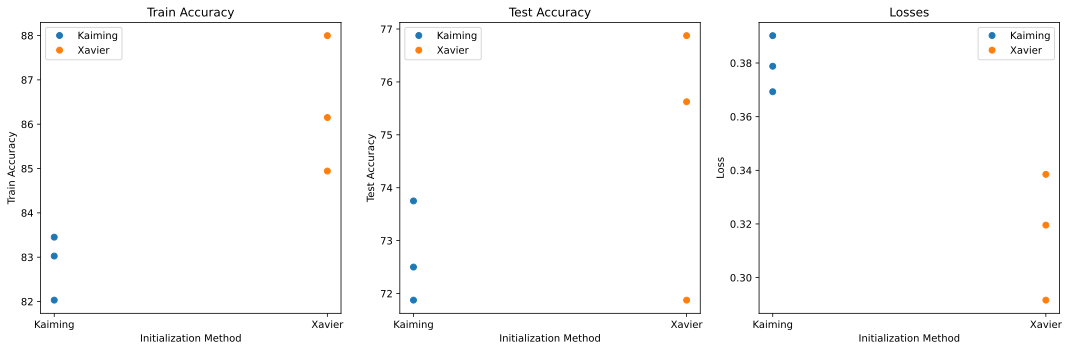

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot train accuracy
ax[0].plot(np.zeros(3), trainAccuracy[:, 0], 'o', label='Kaiming')
ax[0].plot(np.ones(3), trainAccuracy[:, 1], 'o', label='Xavier')
ax[0].set_xlabel('Initialization Method')
ax[0].set_ylabel('Train Accuracy')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Kaiming', 'Xavier'])
ax[0].legend()
ax[0].set_title('Train Accuracy')

# Plot test accuracy
ax[1].plot(np.zeros(3),testAccuracy[:, 0], 'o', label='Kaiming')
ax[1].plot(np.ones(3),testAccuracy[:, 1], 'o', label='Xavier')
ax[1].set_xlabel('Initialization Method')
ax[1].set_ylabel('Test Accuracy')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Kaiming', 'Xavier'])
ax[1].legend()
ax[1].set_title('Test Accuracy')

# Plot losses
ax[2].plot(np.zeros(3), losses_full[:, 0], 'o', label='Kaiming')
ax[2].plot(np.ones(3), losses_full[:, 1], 'o', label='Xavier')
ax[2].set_xlabel('Initialization Method')
ax[2].set_ylabel('Loss')
ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(['Kaiming', 'Xavier'])
ax[2].legend()
ax[2].set_title('Losses')

plt.tight_layout()
plt.show()

In [42]:
import copy

In [38]:
# Create a sequential model
model = nn.Sequential(
    nn.Linear(2, 8),  # Input layer with 2 inputs and 8 hidden units
    nn.ReLU(),       # Activation function
    nn.Linear(8, 1)  # Output layer with 1 output
)


In [43]:
copy.deepcopy(model)

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=1, bias=True)
)

In [29]:
trainAccuracy

array([[82.03125   , 87.99715909],
       [83.45170455, 86.15056818],
       [83.02556818, 84.94318182]])

In [30]:
testAccuracy

array([[73.75000119, 76.87500119],
       [71.875     , 75.62500238],
       [72.50000238, 71.875     ]])

In [32]:
losses_full

array([[0.39020559, 0.29160166],
       [0.36929339, 0.31956872],
       [0.37880006, 0.3384991 ]])

# Compute the performance measures on the train and test data

In [8]:
# predictions for training data
train_predictions = winenet(train_loader.dataset.tensors[0])
train_predictions

# predictions for test data
test_predictions = winenet(test_loader.dataset.tensors[0])
test_predictions

tensor([[ 1.6690],
        [-3.0124],
        [-2.7763],
        [ 8.4076],
        [ 2.1514],
        [-1.0016],
        [-2.2391],
        [ 4.5049],
        [ 0.9227],
        [-3.0481],
        [-0.5753],
        [ 1.2415],
        [ 4.1528],
        [ 3.0438],
        [-4.2462],
        [ 4.1006],
        [-0.4621],
        [ 0.7201],
        [-3.1795],
        [ 4.5602],
        [ 0.2998],
        [ 2.6510],
        [ 6.8276],
        [-3.1663],
        [ 3.1068],
        [ 0.6309],
        [ 2.2595],
        [ 3.7825],
        [-2.4380],
        [ 1.6180],
        [-2.3468],
        [10.5178],
        [-4.2613],
        [ 3.1449],
        [ 0.8274],
        [ 1.2034],
        [ 0.7714],
        [ 3.5147],
        [ 3.2753],
        [-1.8870],
        [-0.2748],
        [ 1.0271],
        [ 3.5523],
        [ 7.4251],
        [ 2.2345],
        [-2.0683],
        [ 5.5511],
        [-1.9467],
        [-1.1862],
        [-0.1715],
        [ 1.6690],
        [ 7.0730],
        [-2.

In [10]:
train_loader.dataset.tensors[1]

tensor([[1.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])

In [11]:
# NEW! using scikitlearn to compute ARPF
import sklearn.metrics as skm

# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions>0)
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions>0)


# test
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions>0)
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions>0)

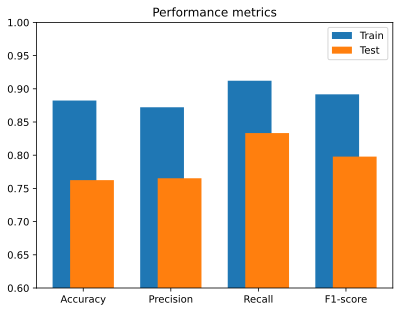

In [12]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.6,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

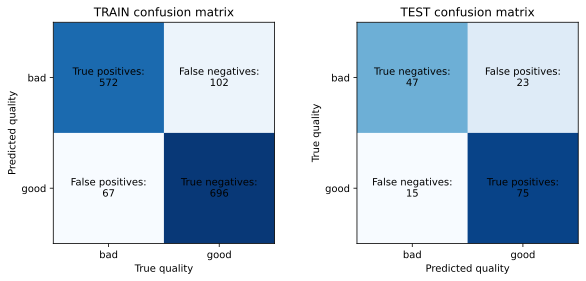

array([[572, 102],
       [ 67, 696]])

In [24]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions>0)
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions>0)

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=len(train_predictions)/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['bad','good'])
ax[0].set_yticklabels(['bad','good'])
ax[0].set_ylabel('Predicted quality')
ax[0].set_xlabel('True quality')
ax[0].set_title('TRAIN confusion matrix')

# add text labels
ax[0].text(1,1,f'True negatives:\n{trainConf[1,1]}' ,ha='center',va='center')
ax[0].text(1,0,f'False negatives:\n{trainConf[0,1]}',ha='center',va='center')
ax[0].text(0,0,f'True positives:\n{trainConf[0,0]}' ,ha='center',va='center')
ax[0].text(0,1,f'False positives:\n{trainConf[1,0]}',ha='center',va='center')




# confmat during TEST
ax[1].imshow(testConf,'Blues',vmax=len(test_predictions)/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['bad','good'])
ax[1].set_yticklabels(['bad','good'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('TEST confusion matrix')

# add text labels
ax[1].text(0,0,f'True negatives:\n{testConf[0,0]}' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{testConf[1,0]}',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{testConf[1,1]}' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{testConf[0,1]}',ha='center',va='center')
plt.show()

trainConf

# Additional explorations

In [ ]:
# 1) The confusion matrices are rotated, in the sense that most visualizations (outside of Python) have reality in the columns
#    and predictions in the rows. Change the code to get the matrices in the orientation shown in the slides. Make sure
#    all the labels are correct! (hint: you might need to consult the help file: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
# 
# 2) Normalize the confusion matrix to 'all' (the total N). The numbers are so long that they're difficult to read! Change
#    the text drawing code to transform the proportion into percent, and show only the first 2 digits after the period.
# 

In [14]:
?skm.confusion_matrix

Signature:
skm.confusion_matrix(
    y_true,
    y_pred,
    *,
    labels=None,
    sample_weight=None,
    normalize=None,
)
Docstring:
Compute confusion matrix to evaluate the accuracy of a classification.

By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` and
predicted to be in group :math:`j`.

Thus in binary classification, the count of true negatives is
:math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
:math:`C_{1,1}` and false positives is :math:`C_{0,1}`.

Read more in the :ref:`User Guide <confusion_matrix>`.

Parameters
----------
y_true : array-like of shape (n_samples,)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,)
    Estimated targets as returned by a classifier.

labels : array-like of shape (n_classes), default=None
    List of labels to index the matrix. This may be used to reorder
    or select a subset of labels.
  

In [16]:
skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions>0, normalize='all')

array([[0.3980515 , 0.07098121],
       [0.04662491, 0.48434238]])

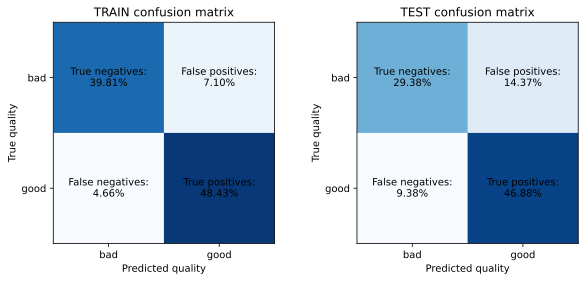

array([[0.3980515 , 0.07098121],
       [0.04662491, 0.48434238]])

In [22]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions>0, normalize='all')
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions>0, normalize='all')

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=1/2)
ax[0].set_xticks([0,1])
ax[0].set_yticks([0,1])
ax[0].set_xticklabels(['bad','good'])
ax[0].set_yticklabels(['bad','good'])
ax[0].set_xlabel('Predicted quality')
ax[0].set_ylabel('True quality')
ax[0].set_title('TRAIN confusion matrix')

# add text labels
ax[0].text(0,0,f'True negatives:\n{trainConf[0,0]*100:.2f}%' ,ha='center',va='center')
ax[0].text(0,1,f'False negatives:\n{trainConf[1,0]*100:.2f}%',ha='center',va='center')
ax[0].text(1,1,f'True positives:\n{trainConf[1,1]*100:.2f}%' ,ha='center',va='center')
ax[0].text(1,0,f'False positives:\n{trainConf[0,1]*100:.2f}%',ha='center',va='center')




# confmat during TEST
ax[1].imshow(testConf,'Blues',vmax=1/2)
ax[1].set_xticks([0,1])
ax[1].set_yticks([0,1])
ax[1].set_xticklabels(['bad','good'])
ax[1].set_yticklabels(['bad','good'])
ax[1].set_xlabel('Predicted quality')
ax[1].set_ylabel('True quality')
ax[1].set_title('TEST confusion matrix')

# add text labels
ax[1].text(0,0,f'True negatives:\n{testConf[0,0]*100:.2f}%' ,ha='center',va='center')
ax[1].text(0,1,f'False negatives:\n{testConf[1,0]*100:.2f}%',ha='center',va='center')
ax[1].text(1,1,f'True positives:\n{testConf[1,1]*100:.2f}%' ,ha='center',va='center')
ax[1].text(1,0,f'False positives:\n{testConf[0,1]*100:.2f}%',ha='center',va='center')
plt.show()

trainConf